In [3]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

plt.ion()

In [15]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

img_name = landmarks_frame.iloc[65, 0]
landmarks = landmarks_frame.iloc[65, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2) # x, y

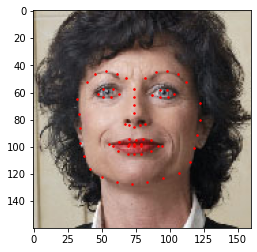

In [75]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

### Dataset 클래스

`torch.utils.data.Dataset`은 데이터셋을 나타내는 추상클래스입니다. 여러분의 데이터셋은 `Dataset`에 상속하고 아래와 같이 오버라이드 해야합니다.

* `len(dataset)`에서 호출되는 `__len__`은 데이터셋의 크기를 리턴해야합니다.

* `dataset[i]`에서 호출되는 `__getitem__`은 i번째 샘플을 찾는데 사용됩니다.

이제 데이터셋 클래스를 만들어보도록 하겠습니다. `__init__`을 사용해서 CSV 파일 안에 있는 데이터를 읽지만, `__getitem__`을 이용해서 이미지의 판독을 합니다. 이 방법은 모든 이미지를 메모리에 저장하지 않고 필요할때마다 읽기 때문에 메모리를 효율적으로 사용합니다.

데이터셋의 샘플은 `{'image': image, 'landmarks': landmarks}` 의 사전 형태를 갖습니다. 선택적 인자인 `transform`을 통해 필요한 전처리 과정을 샘플에 적용할 수 있습니다. 다음 장에서 전이 `transform`의 유용성에 대해 알아보겠습니다.

In [76]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        """
            csv_file (string): csv 파일의 경로
            data_dir (string): 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_file = os.path.join(self.data_dir, self.landmarks_frame.iloc[idx, 0])
        img = io.imread(img_file)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': img, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        

0 (324, 215, 3) (68, 2)


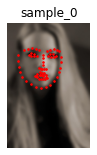

1 (500, 333, 3) (68, 2)


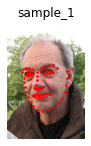

2 (250, 258, 3) (68, 2)


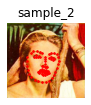

3 (434, 290, 3) (68, 2)


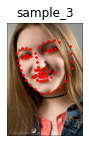

In [77]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    data_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('sample_{}'.format(i))
    ax.axis('off')

    show_landmarks(**sample)
        
    if i == 3:
        plt.show()
        break

### Transforms

위에서 볼 수 있었던 한가지 문제점은 샘플들이 다 같은 사이즈가 아니라는 것입니다. 대부분의 신경망(neural networks)은 고정된 크기의 이미지라고 가정합니다. 그러므로 우리는 신경망에 주기 전에 처리할 과정을 작성해야 합니다.

3가지의 transforms 을 만들어 봅시다: 

- Rescale: 이미지의 크기를 조절합니다.

- RandomCrop: 이미지를 무작위로 자릅니다.

이것을 data augmentation이라 합니다.

- ToTensor: numpy 이미지에서 torch 이미지로 변경합니다. (축변환이 필요합니다)

간단한 함수대신에 호출 할 수 있는 클래스로 작성 합니다. 이렇게 한다면, 클래스가 호출 될 때마다 전이(Transform)의 매개변수가 전달 되지 않아도 됩니다. 이와 같이, __call__ 함수를 구현해야 합니다. 필요하다면, __init__ 함수도 구현해야 합니다. 다음과 같이 전이(transform)를 사용할 수 있습니다.

In [85]:
class Rescale(object):
    """
    주어진 사이즈로 샘플크기를 조정합니다.

    Args:
        output_size(tuple or int) : 원하는 사이즈 값
            tuple인 경우 해당 tuple(output_size)이 결과물(output)의 크기가 되고,
            int라면 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됩니다.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
            
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks*[new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}
        

In [91]:
class RandomCrop(object):
    """
        샘플데이터를 무작위로 자릅니다.

    Args:
        output_size (tuple or int): 줄이고자 하는 크기입니다.
                        int라면, 정사각형으로 나올 것 입니다.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left+ new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}


In [105]:
class ToTensor(object):
    """
    numpy array를 tensor(torch)로 변환 시켜줍니다.
    """

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
        

### Compose transforms

이제, 샘플에 전이(transform)를 적용해 봅시다.

이미지의 가장 짧은 측면을 256개로 rescale하고, 그후에 무작위로 224개를 자른다고 가정합시다. 다시말해, `Rescale`과 `RandomCrop`을 사용해봅시다.

`torchvision.transforms.Compose`는 위의 두작업을 하는 간단한 호출할 수 있는 클래스입니다.

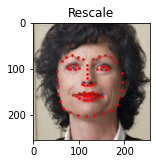

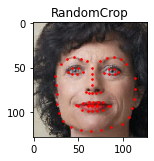

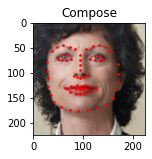

In [106]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

### 데이터셋을 이용한 반복작업

전이(transform)를 적용한 dataset을 만들기위해서 만들었던것을 다 집어 넣어 봅시다.

이미지는 파일 전체를 메모리에 올리지않고 필요할때마다 불러와서 읽습니다.

그 후에 읽은 이미지에 Transform을 적용합니다.

transfroms 중 하나가 랜덤이기 때문에, 데이터는 샘플링때 증가합니다.


In [107]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           data_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [109]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


그러나, 데이터 상에서 반복하는 for 문은 많은 특징(features)를 놓칠 수 있습니다. 특히, 아래와 같은 것을 놓칠 수 있습니다:

* 데이터를 묶는 과정

* 데이터를 섞는 과정

* 병렬처리 과정에서 `multiprocessing`을 사용할때 데이터를 불러오는 것

`torch.utils.data.DataLoder`는 위와 같은 기능을 모두 제공해주는 반복자(iterator)입니다. 사용되는 매개변수(Parameters)는 명확해야 합니다. `collate_fn`는 흥미로운 매개변수(Parameters) 중 하나입니다. `collate_fn을 이용하여 샘플들을 정확하게 배치하는 방법을 명시할 수 있습니다. 그러나, 대부분의 경우에 대해서 정확하게 작동해야 합니다.



In [110]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


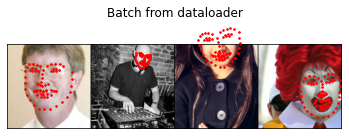

In [111]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Afterword: torchvision

이번 튜토리얼에서는, 데이터셋 작성과 사용, 전이(transforms), 데이터를 불러오는 방법에 대해서 알아봤습니다. torchvision 패키지는 몇몇의 일반적인 데이터셋과 전이(transforms)들을 제공합니다. 클래스들을 따로 작성하지 않아도 될 것입니다. torchvision에서의 사용가능한 일반적인 데이터셋 중 하나는 ImageFolder 입니다. 이것은 다음과 같은 방식으로 구성되어 있다고 가정합니다:

`
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
`

여기서’ants’, ‘bees’는 class labels입니다. 비슷하게, RandomHorizontalFlip , Scale 과 같이 PIL.Image 에서 작동하는 일반적인 전이(transforms)도 사용가능합니다. 이와 같이 데이터로더(dataloader)를 사용할 수 있습니다:
```
 import torch
 from torchvision import transforms, datasets

 data_transform = transforms.Compose([
         transforms.RandomSizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
     ])
 hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                            transform=data_transform)
 dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                              batch_size=4, shuffle=True,
                                              num_workers=4)
```
training code에 대한 예시를 알고 싶다면,

:doc:`transfer_learning_tutorial` 문서를 참고해주세요